<a href="https://colab.research.google.com/github/davidisinta/healthy_way/blob/main/food_classifier_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

food classifier

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


download the dataset if it doesnt exist

In [2]:
from __future__ import absolute_import, division, print_function

import cv2
import os
import random
import collections
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.resnet50 import decode_predictions, preprocess_input

from google.colab.patches import cv2_imshow


In [3]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [4]:
# Download data and extract it to folder
get_data_extract()

4996278331/4996278331 ━━━━━━━━━━━━━━━━━━━━ 255s 0us/step
Dataset downloaded and extracted!


Visualize random data from the Dataset

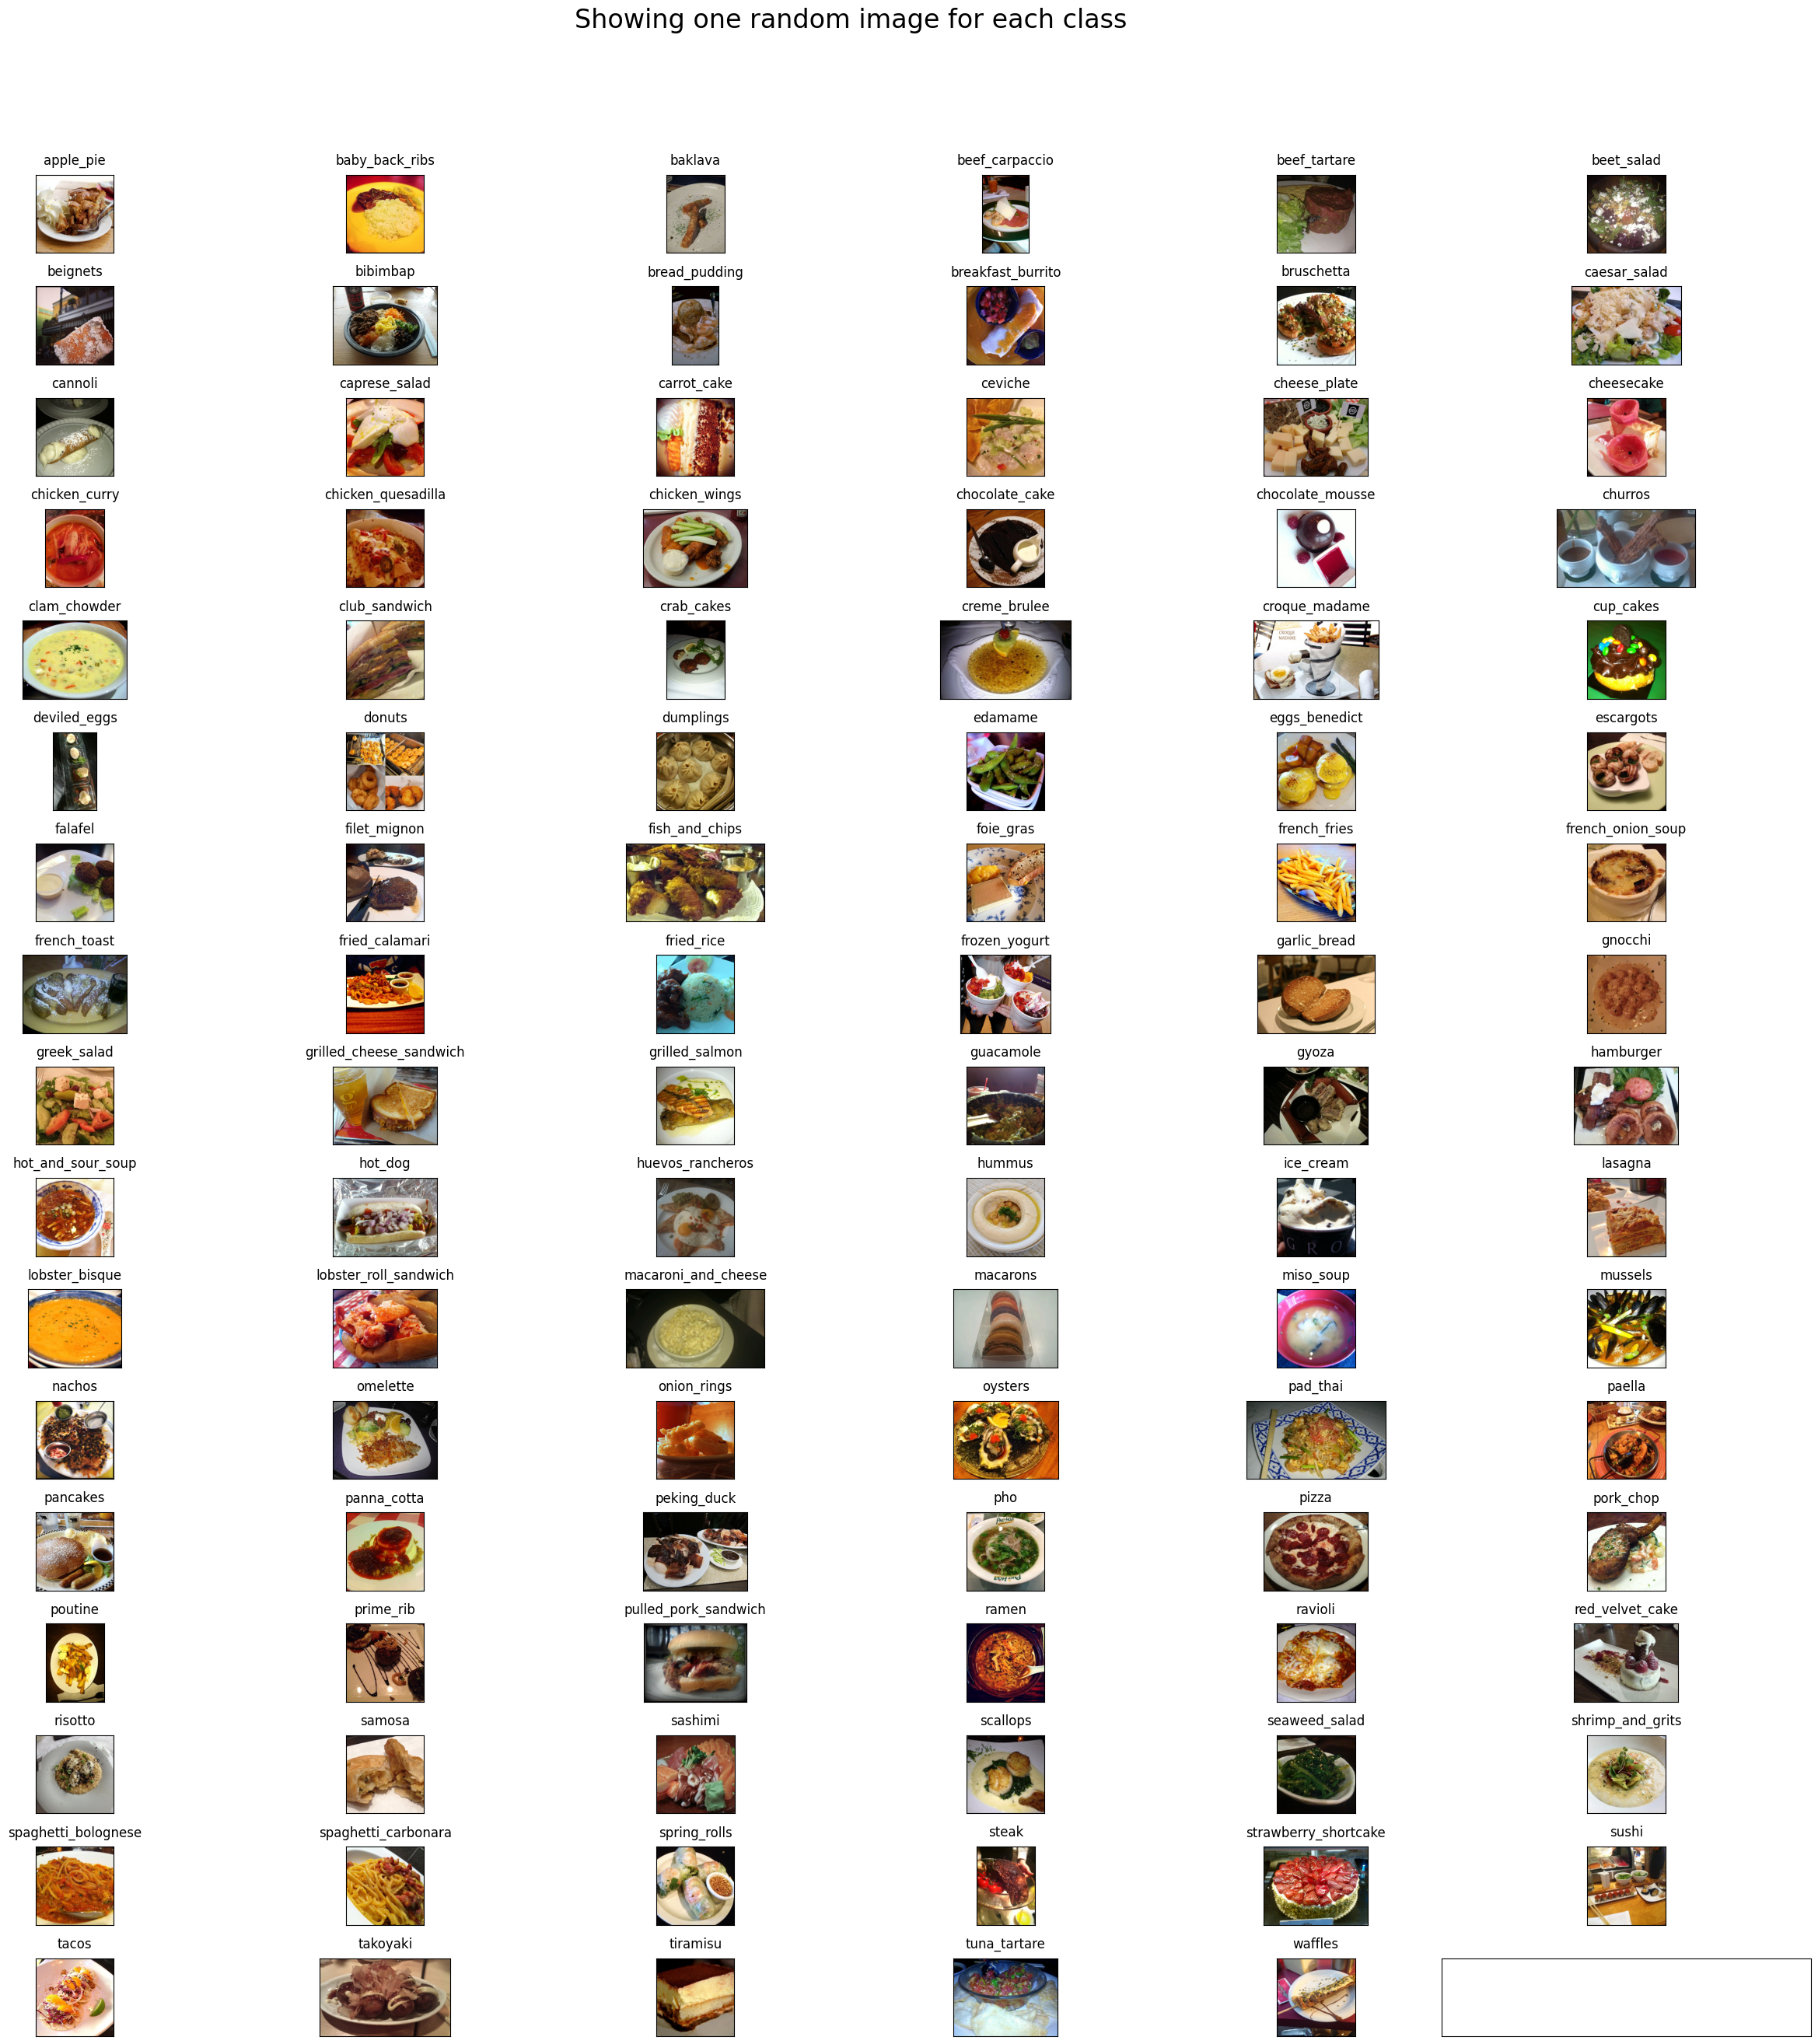

In [5]:
rows = 17
cols = 6
# this choice of rows and columns is because the product results in 102, and there are 101 classes


fig, ax = plt.subplots(rows, cols, figsize=(25,25))
# subplots not to be mistaken with subplot

fig.suptitle("Showing one random image for each class", y=1.05, fontsize=24)
# Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue

# let's grab our image directory. We'll name the directory data_dir
data_dir = '/content/food-101/images'

food_sorted = sorted(os.listdir(data_dir)) # start from inner function

# create a food_id counter to exit the for loop
food_id = 0

# now let's loop through the row and column length we specified

for i in range(rows): # this will make the loop exit when the number of rows are exhausted
  for j in range(cols):
    try:
      # now we select the alphabetically listed food classes(folder names) in order
      food_selected= food_sorted[food_id]
      food_id+=1
    except:
      break

    # let's grab the list of all files present in each food category
    food_selected_images = os.listdir(os.path.join(data_dir, food_selected))

    food_selected_random = np.random.choice(food_selected_images)


    img = plt.imread(os.path.join(data_dir, food_selected, food_selected_random))

    # Let's now display these randomly selected images
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad=10)

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()


Split data into train and test sets

In [6]:
# Helper method to split the images into trainng and test folders
def train_test_cleave(filepath, src, dest):

  img_classes = defaultdict(list)

  # open up the filepath
  # use list comprehension to strip the link of whitespaces
  # create a map of the images
  with open(filepath, 'r') as txt:
    paths = [read.strip() for read in txt.readlines()]
    for p in paths:
      food = p.split('/')
      img_classes[food[0]].append(food[1] + '.jpg')

    from shutil import copy

    # iterate over the food keys in the img_classes dictionary
  for food in img_classes:
    print("\n Copying images into {} ...".format(food))
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in img_classes[food]:
      # import:: from shutil import copy
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copy complete...")

In [7]:
# Copy images from food-101/images to food-101/train based on the train.txt
print("\n Creating training set...")
train_test_cleave('/content/food-101/meta/train.txt', 'food-101/images', 'food-101/train')


 Creating training set...

 Copying images into apple_pie ...

 Copying images into baby_back_ribs ...

 Copying images into baklava ...

 Copying images into beef_carpaccio ...

 Copying images into beef_tartare ...

 Copying images into beet_salad ...

 Copying images into beignets ...

 Copying images into bibimbap ...

 Copying images into bread_pudding ...

 Copying images into breakfast_burrito ...

 Copying images into bruschetta ...

 Copying images into caesar_salad ...

 Copying images into cannoli ...

 Copying images into caprese_salad ...

 Copying images into carrot_cake ...

 Copying images into ceviche ...

 Copying images into cheesecake ...

 Copying images into cheese_plate ...

 Copying images into chicken_curry ...

 Copying images into chicken_quesadilla ...

 Copying images into chicken_wings ...

 Copying images into chocolate_cake ...

 Copying images into chocolate_mousse ...

 Copying images into churros ...

 Copying images into clam_chowder ...

 Copying i

In [8]:
# Copy imageas from food-101/images to food-101/test based on the test.txt
print("\n Creating test set...")
train_test_cleave('/content/food-101/meta/test.txt', 'food-101/images', 'food-101/test')


 Creating test set...

 Copying images into apple_pie ...

 Copying images into baby_back_ribs ...

 Copying images into baklava ...

 Copying images into beef_carpaccio ...

 Copying images into beef_tartare ...

 Copying images into beet_salad ...

 Copying images into beignets ...

 Copying images into bibimbap ...

 Copying images into bread_pudding ...

 Copying images into breakfast_burrito ...

 Copying images into bruschetta ...

 Copying images into caesar_salad ...

 Copying images into cannoli ...

 Copying images into caprese_salad ...

 Copying images into carrot_cake ...

 Copying images into ceviche ...

 Copying images into cheesecake ...

 Copying images into cheese_plate ...

 Copying images into chicken_curry ...

 Copying images into chicken_quesadilla ...

 Copying images into chicken_wings ...

 Copying images into chocolate_cake ...

 Copying images into chocolate_mousse ...

 Copying images into churros ...

 Copying images into clam_chowder ...

 Copying image

use a subset of the food 101 dataset that contains only 4 classes because it takes lots of compute to train 101 classes

In [10]:
mini_list = ["caesar_salad", "steak", "waffles", "fried_rice"]
src_train = "food-101/train"
dest_train = "food-101/train_mini"
src_test = "food-101/test"
dest_test = "food-101/test_mini"

In [11]:
def sample_datset(food_list, src, dest):
  if os.path.exists(dest):
    # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
    rmtree(dest)
  os.makedirs(dest)

  for food_item in food_list:
    print("Copying images from {} to {}/{} ...".format(src, dest, food_item))
    copytree(os.path.join(src, food_item), os.path.join(dest,food_item))
    print("Done!")

In [12]:
print("Creating train data folder with 4 new classes")
sample_datset(mini_list, src_train, dest_train)

Creating train data folder with 4 new classes
Copying images from food-101/train to food-101/train_mini/caesar_salad ...
Done!
Copying images from food-101/train to food-101/train_mini/steak ...
Done!
Copying images from food-101/train to food-101/train_mini/waffles ...
Done!
Copying images from food-101/train to food-101/train_mini/fried_rice ...
Done!


In [13]:
print("Creating test data folder with new classes")
sample_datset(mini_list, src_test, dest_test)

Creating test data folder with new classes
Copying images from food-101/test to food-101/test_mini/caesar_salad ...
Done!
Copying images from food-101/test to food-101/test_mini/steak ...
Done!
Copying images from food-101/test to food-101/test_mini/waffles ...
Done!
Copying images from food-101/test to food-101/test_mini/fried_rice ...
Done!


In [14]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
3000


In [15]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
1000


Fine tune ResNet50 on Food101 dataset

In [16]:
def train_model(n_categories, num_epochs, num_train_samples, num_validation_samples):

  K.clear_session() # we clear the session to provide a faster impplemenmtation of the model

  img_width, img_height = 299, 299
  train_data_dir = "food-101/train_mini"
  validation_data_dir = "food-101/test_mini"
  batch_size = 20
  bestmodel_path = "bestmodel_" + str(n_categories)+"classes.keras"
  trainedmodel_path = 'trainedmodel_'+ str(n_categories)+ "class.keras"
  history_path = 'history_'+str(n_categories)+'.log'

  train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      rescale=1. / 255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  test_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical'
  )

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical'
  )


  # Cool. Now let's create an instance of our Resnet50 model
  resnet_awesome = ResNet50(include_top=False, weights='imagenet')
  x = resnet_awesome.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.2)(x)


  #Let's create an object to hold our predictions.
  predictions = Dense(n_categories, kernel_regularizer=regularizers.l2(0.0049), activation='softmax')(x)
  # The softmax function is an activation function that turns numbers into probabilities which sum to one.
  # The softmax function outputs a vector that represents the probability distributions of a list of outcomes
  #It is useful for finding out the class which has the max. Probability.
  #The Softmax function is ideally used in the output layer,
  # where we are actually trying to attain the probabilities to define the class of each input.

  # We now have the basic architecture for fine-tuning the Resnet50. But we cant train it this way.
  # What we now do is create an instance of the Model. We do this by [assing our architecture into
  # the Model class, which takes in the details of the input and output of our model architecture.
  # Let's import the Model class now.

  model = Model(inputs=resnet_awesome.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

  # since we are working with a multi-class problem (which should not be confused with multi-label problems),
  # we make use of categorical_crossentropy loss and the softmax function.
  # If on the other hand we were dealing with a multi-label problem, we would then probably use
  # binary_crossentropy and the sigmoid activation for the final layer.


  # Let's now create checkpoint and csv error logger callbacks

  # A callback is a powerful tool to customize the behavior of a Keras model during training,
  # evaluation, or inference, including reading/changing the Keras model.
  # Callback is a python class meant to be subclassed to provide specific functionality,
  # with a set of methods called at various stages of training (including batch/epoch start and ends),
  # testing, and predicting. In this case, we will be using built-in callbacks.
  # However, in subsequent tutorials, I will be going over how you can build your own custom callback classes.


  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)

  # This creates a saved version of our best performing model.
  # setting verbose=0 means verbose is false. This means we wont see any output during training

  csv_logger = CSVLogger(history_path)

  # The CSVLogger contains the loss value, and all the metrics at the end of a batch or epoch

  # Use floor division operator // to return floor value
  # for both integer and floating point arguments.
  # In python, the floor of x is the largest integer not greater than x

  history = model.fit(train_generator,
                                steps_per_epoch = num_train_samples // batch_size,
                                validation_data=validation_generator,
                                validation_steps=num_validation_samples//batch_size,
                                epochs=num_epochs,
                                verbose =1,
                                callbacks=[csv_logger, checkpoint])
  ## Call the save method
  model.save(trainedmodel_path)
  # The dictionary containing the mapping from class names to class indices
  # can be obtained via the attribute "class_indices"
  class_map = train_generator.class_indices
  return history, class_map

Train the Model

In [17]:
# Train the model with data from 4 classes
n_classes = 4
epochs = 1
num_train_samples = train_files
num_validation_samples = test_files

history, class_map_4 = train_model(n_classes, epochs, num_train_samples, num_validation_samples)
print(class_map_4)

Found 3000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.5798 - loss: 1.1695 
Epoch 1: val_loss improved from inf to 5.25713, saving model to bestmodel_4classes.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5022s 33s/step - accuracy: 0.5803 - loss: 1.1683 - val_accuracy: 0.2500 - val_loss: 5.2571
{'caesar_salad': 0, 'fried_rice': 1, 'steak': 2, 'waffles': 3}


# Predicting classes for new images from internet images using our best trained model

In [18]:
# Load the best saved model to make predictions

K.clear_session()
## import:: from tensorflow.keras.models import load_model
model_best = load_model("/content/trainedmodel_4class.keras", compile=False)

In [19]:
def predict_class(model, picture, show = True, rescale=1. / 255):
  pic = kimage.load_img(picture, target_size=(299, 299))
  pic = kimage.img_to_array(pic)
  pic = np.expand_dims(pic, axis=0)
  pic *= rescale
  #pic = preprocess_input(pic)

  pred = model.predict(pic)
  index = np.argmax(pred)

  mini_list.sort()
  pred_value = mini_list[index]

  if show:
      plt.imshow(pic[0])
      plt.axis('off')
      plt.title(pred_value)
      plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


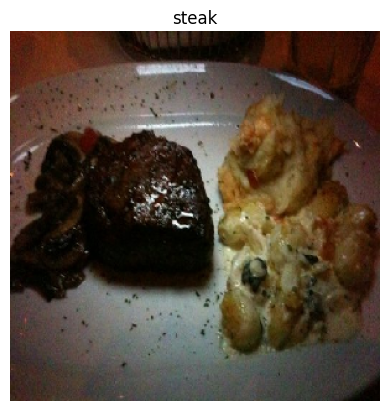

In [20]:
imagepath = '/content/food-101/test_mini/steak/100274.jpg'
predict_class(model_best, imagepath, True)